(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Yelp Reviews and Clustering

In this assignment, we will be working with the [Yelp dataset](http://cs-people.bu.edu/kzhao/teaching/yelp_dataset_challenge_academic_dataset.tar). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

First, we will look at Review Objects and perform some [sentiment analysis](http://sentiment.christopherpotts.net/) on the review text.

You will need to preprocess the text using a stemming algorithm. The Porter stemming algorithm is a well-known one. Then, use a lexicon to assign a score to a review based on the positive/negative words you find in the text. You can find various lexicons [here](http://sentiment.christopherpotts.net/lexicons.html).

After you have assigned scores to the reviews based on the text analysis, compare your scores with the stars associated with the reviews. **(20 pts)**

In [ ]:
import json
import numpy as np 
import string 
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

path = "/Users/ALaw/Desktop/Stuff/2016 Spring/591/submissions/591-hw/hw2-submission/yelp_dataset_challenge_academic_dataset/"
filename = path + "yelp_academic_dataset_review.json"

#Read through the Vader lexicon, put them into global dictionary "Vwords"
lexicons = open("/Users/ALaw/Desktop/Stuff/2016 Spring/591/submissions/591-hw/hw2-submission/vader_lexicon.txt",'r')
Vwords = dict()
for line in lexicons:
    line = line.split('\t')
    Vwords[line[0]] = [float(line[1]),float(line[2])]
lexicons.close()

#Sentiment scoring function
def sentiment_score(line):
    '''reads a string and runs a stemmer to break down words to evaluate sentimental score'''
    length = len(line)*1.0
    line = line.lower()
    line = line.strip(string.punctuation)
    line = line.split()
    raw = 0.0
    numV = 1.0
    for i in line:
        if i in Vwords:
            raw += Vwords[i][0] 
            numV += 1.0
            
    if length == 0:
        print(line)
    
    return raw * (numV/length)


#Parse function
def parse(fn=filename):
    '''Read line by line and extract (x,y) coordinates, where x = sentiment intensity and y = star rating'''
    
    data= []
    
    with open(fn,'r') as f:
        for line in f:
            json_line = json.loads(line)
            scores = sentiment_score(json_line['text'])
            stars = json_line['stars']
            data.append((stars,scores))
    
    data = pd.DataFrame(data,columns = ['stars','sentiment'])
    data = data.sort_values('sentiment')
    data = data.drop(data.index[[0,1]])
    data = data.drop(data.index[[2225209,2225210]])
    data = data.sort_values('stars')
    data.to_csv('review_data.csv')
    return data

#test case for parse + sentiment scoring, drops outlier cases
start = time.time()
d = parse()
end = time.time() - start
print("Completed, Time: " + str(end))

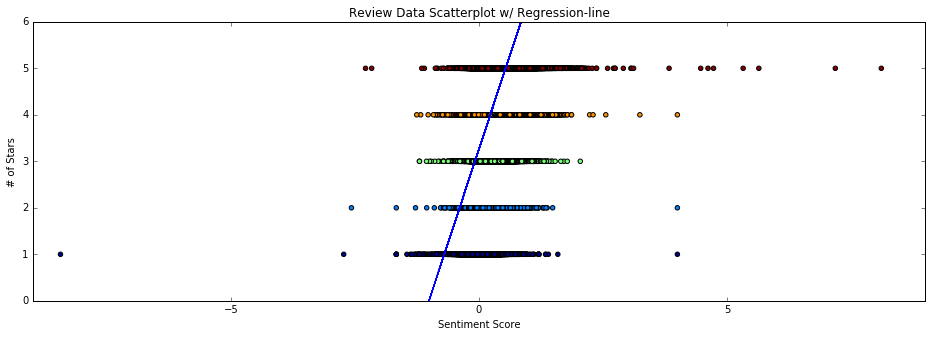

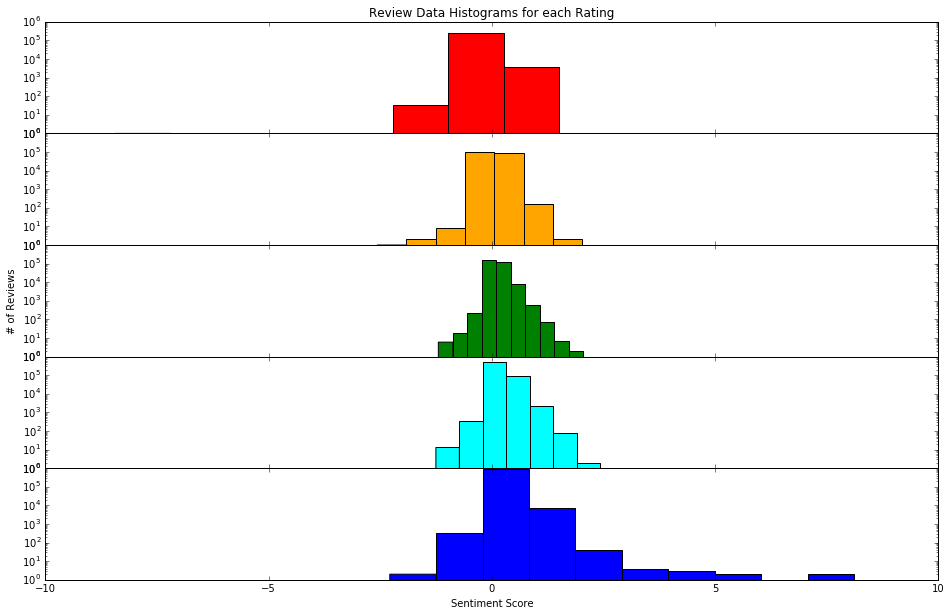

Statistics for data:

# of 1 Star Reviews: 260491
Avg Sentiment of Reviews: 0.00653886895422
Variance of Sentiment: 0.0104978961361

# of 2 Star Reviews: 190047
Avg Sentiment of Reviews: 0.0692810569514
Variance of Sentiment: 0.0114445732897

# of 3 Star Reviews: 282115
Avg Sentiment of Reviews: 0.121118894836
Variance of Sentiment: 0.0166858752912

# of 4 Star Reviews: 591618
Avg Sentiment of Reviews: 0.178268423107
Variance of Sentiment:0.0246182247143

# of 5 Star Reviews: 900938
Avg Sentiment of Reviews: 0.204185523779
Variance of Sentiment: 0.0310080205299

Line of Regression: Y = 3.237147 * X + (3.2637)
		    Y = Star rating X = Sentiment score
Mean Square Error of Regression: 1.5751


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

%matplotlib inline

path = "/Users/ALaw/Desktop/Stuff/2016 Spring/591/submissions/591-hw/hw2-submission/"
dataname = path + "review_data.csv"

try:
    data = pd.DataFrame.from_csv(dataname)
except IOError:
    data = parse()

def visualize(data):
    '''Visualizes the sentiment vs star rating data through a scatter plot and runs linear regression'''
    
    x = np.array(data['sentiment'])
    y = np.array(data['stars'])
    n = len(data.index)
    
    plt.figure(figsize=(16,5))
    plt.scatter(x, y, c = y)
    plt.title('Review Data Scatterplot w/ Regression-line')
    plt.ylabel('# of Stars')
    plt.xlabel('Sentiment Score') 

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x))
    
    plt.xlim([-9,9])
    plt.ylim([0,6])
    plt.show()

    s1_data = list(data[(data['stars'] == 1)]['sentiment'])
    s2_data = list(data[(data['stars'] == 2)]['sentiment'])
    s3_data = list(data[(data['stars'] == 3)]['sentiment'])
    s4_data = list(data[(data['stars'] == 4)]['sentiment'])
    s5_data = list(data[(data['stars'] == 5)]['sentiment'])
     
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, sharey=True,figsize=(16,10))
    ax1.hist(s1_data, color = 'red')
    ax1.set_title('Review Data Histograms for each Rating')
    ax1.set_yscale('log')
    ax2.hist(s2_data, color = 'orange')
    ax2.set_yscale('log')
    ax3.hist(s3_data, color = 'green')
    ax3.set_ylabel('# of Reviews')
    ax3.set_yscale('log')
    ax4.hist(s4_data, color = 'cyan')
    ax4.set_yscale('log')
    ax5.hist(s5_data)
    ax5.set_xlabel('Sentiment Score')
    ax5.set_yscale('log')
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.show()
    
    print("Statistics for data:\n")
    print("# of 1 Star Reviews: " + str(len(s1_data)))
    print("Avg Sentiment of Reviews: "+ str(np.mean(s1_data)))
    print("Variance of Sentiment: "+ str(np.var(s1_data)))
    print("")
    print("# of 2 Star Reviews: " + str(len(s2_data)))
    print("Avg Sentiment of Reviews: "+ str(np.mean(s2_data)))
    print("Variance of Sentiment: "+ str(np.var(s2_data)))
    print("")
    print("# of 3 Star Reviews: " + str(len(s3_data)))
    print("Avg Sentiment of Reviews: "+ str(np.mean(s3_data)))
    print("Variance of Sentiment: "+ str(np.var(s3_data)))
    print("")
    print("# of 4 Star Reviews: " + str(len(s4_data)))
    print("Avg Sentiment of Reviews: "+ str(np.mean(s4_data)))
    print("Variance of Sentiment:"+ str(np.var(s4_data)))
    print("")
    print("# of 5 Star Reviews: " + str(len(s5_data)))
    print("Avg Sentiment of Reviews: "+ str(np.mean(s5_data)))
    print("Variance of Sentiment: "+ str(np.var(s5_data)))
    print("")
    print("Line of Regression: Y = %4f * X + (%.4f)\n\t\t    Y = Star rating X = Sentiment score"%(z[0],z[1]))
    print("Mean Square Error of Regression: %.4f"% mean_squared_error(y, p(x)))
    
visualize(data)


Visualization and short (detailed) analysis. **(10 pts)**

Above is a detailed breakdown of sentiment values for each star review. Each review was broken down word by word before running through a sentiment scoring function to determine the scoring. In this regard, I found Bing Liu's method of sentiment scoring to be too simplistic as the results weren't as clear as I hoped. Certain words should carry more sentiment than others; postitive words such as "okay" and "great" or "awesome" shouldn't carry the same value. Thus I made use of the VADER lexicon set: this provided a more accurate sentiment breakdown of common adjectives and adverbs. It also doesn't require stemming to match keys or words; multiple variations of all words are available in the lexicon set. I also took into account the frequency of "sentiment laden" words in the whole review, the logic being that the more complaints/praise one had the more they would express it in a review, as well as to distinguish neutral/objective reviews. 

The dataset had a few outliers which I had to manually remove. They were skewed and obviously were not serious, throwing off the regression analysis and the graph. They are listed below:

723985 - Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude Rude rude rude

1019106 - bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad bad

1882507 - Love love love love love love love love love love love love love love love love love love love love love"\

915634 - Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing Amazing need I say more

Overall the distribution of sentiment for each level of rating was quite normal; the means and variance of scores were close to 0 and there were very few outliers. Where there were outliers, there reviews tend to be overly sentimental but within reason, so I left them in the dataset. The position of outliers also expressed the difference in negative and positive reviews: 1 star reviews had outliers to the left, and 5 star reviews had them on the right, with only one or two exceptions. The vast majority of reviews at each level of rating tend to fall within 0.5 of 0. It is interesting to note too that the mean and variance increased as the level of rating increased, suggesting that the sentiment expressed get more and more postive when the review was higher. The regression line also suggested a positive linear relationship between ratings and sentiment. The means squared error shows that there is some degree of inaccuracy due to the the large spread of scores across any one rating, as well as the spread of outliers.

Based on the analysis, I conclude that sentiment analysis is indeed effective in determining the rating of a review. Posters tend to be more clear about negative reviews than in postive ones too, explaining the variance in negative reviews compared to positive ones. Another thing to note is that many tend to rate their experiences very differently: a 1 star experience could be another person's 3 star experience, or 5 compared to 4. However the overall effective of multiple reviews allows for a more accurate calculation of sentiment compared to star ratings.


-----------------

Now, let's look at Business Objects. Try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" and "attributes" to cluster for similarity.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

Things you may want to consider:
1. The spatial coordinates and restaurant categories/attributes have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.
2. Some restaurant types are inherently more common than others. For example, there are probably lots of "pizza" restaurants. You may want to normalize your vectors so that you don't end up with only clusters of "pizza" restaurants.

In [1]:
import json
import numpy as np 
import string 
import matplotlib.pyplot as plt
import pandas as pd
import time

%matplotlib inline

path = "/Users/ALaw/Desktop/Stuff/2016 Spring/591/submissions/591-hw/hw2-submission/yelp_dataset_challenge_academic_dataset/"
filename = path + "yelp_academic_dataset_business.json"

#Extract function
def extract(fn=filename):
    '''Read line by line, only if:
           -"city": "Las Vegas"
           -"categories" contains "Restaurant"
       then extract (lat,long) categories and attributes
                                           ["Good for"]:{"dessert", "latenight", "lunch", "dinner", "breakfast", "brunch"}
                                           ["Ambience"]:{"romantic", "intimate", "classy", "hipster", "divey", "touristy", "trendy", "upscale", "casual"}
                                           ["Price Range"]: 1-5 (0 if error)
    '''
    
    #First pass: collect information for attribute and categories columns
    cat_col = []
    with open(fn,'r') as f:
        for line in f:
            json_line = json.loads(line)
            if json_line['city'] == 'Las Vegas' and 'Restaurants' in json_line['categories']:
                cat = json_line['categories']
                cat_col += cat
    
    cat_col = list(set(cat_col)) 
    good_for = ["dessert", "latenight", "lunch", "dinner", "breakfast", "brunch"]
    ambience = ["romantic", "intimate", "classy", "hipster", "divey", "touristy", "trendy", "upscale", "casual"]
    
    #remove irrelevant categories
    cat_col.remove('Restaurants')
    cat_col.remove('Buffets')
    cat_col.remove('Gluten-Free')
    cat_col.remove('Arts & Entertainment')
    cat_col.remove('Organic Stores')
    cat_col.remove('Venues & Event Spaces')
    cat_col.remove('Karaoke')
    cat_col.remove('Grocery')
    cat_col.remove('Food Delivery Services')
    cat_col.remove('Bowling')
    cat_col.remove('Event Planning & Services')
    cat_col.remove('Caterers')
    cat_col.remove('Dance Clubs')
    cat_col.remove('Automotive')
    cat_col.remove('Seafood Markets')
    cat_col.remove('Bakeries')
    cat_col.remove('Butcher')
    cat_col.remove('Fruits & Veggies')
    cat_col.remove('Lounges')
    cat_col.remove('Gas & Service Stations')
    cat_col.remove('Performing Arts')
    cat_col.remove('Adult Entertainment')
    cat_col.remove('Casinos')
    cat_col.remove('Plumbing')
    cat_col.remove('Hookah Bars')
    cat_col.remove('Chicken Shop')
    cat_col.remove('Convenience Stores')
    cat_col.remove('Swimming Pools')
    cat_col.remove('Heating & Air Conditioning/HVAC')
    cat_col.remove('Fast Food')
    cat_col.remove('Home Services')
    cat_col.remove('Pool Halls')
    cat_col.remove('Hotels & Travel')
    cat_col.remove('Music Venues')
    cat_col.remove('Jazz & Blues')
    cat_col.remove('Party & Event Planning')
    cat_col.remove('Meat Shops')
    cat_col.remove('Arcades')
    cat_col.remove('Festivals')
    cat_col.remove('Nightlife')
    cat_col.remove('Beer, Wine & Spirits')
    
    cat_col.remove('Food')
    cat_col.remove('Pizza')
    cat_col.remove('Sandwiches')
    cat_col.remove('Hotels')
    
    #Second pass: organize data into dataframe with all the appropiate columns: coordinates, 162 categories, "Good for", "ambience" and "price_range" attributes
    data = []
    with open(fn,'r') as f:
        for line in f:
            json_line = json.loads(line)
            data_line = []
            if json_line['city'] == 'Las Vegas' and 'Restaurants' in json_line['categories']:
                data_line.append(json_line['latitude'])
                data_line.append(json_line['longitude'])
                
                # 0/1s for each category available 
                for types in cat_col: 
                    if types in json_line['categories']:
                        data_line.append(1)
                    else:
                        data_line.append(0)
                
                # True/False for each "good for" attribute
                for kinds in good_for: 
                    try:
                        if json_line['attributes']['Good For'][kinds]:
                            data_line.append(1)
                        else:
                            data_line.append(0)
                    except KeyError:
                        data_line.append(0)
                        
                # True/False for each "ambience" attribute
                for kinds in ambience:
                    try:
                        if json_line['attributes']['Ambience'][kinds]:
                            data_line.append(1)
                        else:
                            data_line.append(0)
                    except KeyError:
                        data_line.append(0)
                        
                #Append price range attribute (0 if error) 1- 5
                try:
                        data_line.append(json_line['attributes']['Price Range'])
                except KeyError:
                        data_line.append(0)
                
                data.append(data_line)
                
    df = pd.DataFrame(data, columns = ['latitude','longitude'] + cat_col + good_for + ambience + ['Price Range'])
    df.to_csv('business_data.csv')
    return df

#test case for extracting data
start = time.time()
e = extract()
end = time.time() - start
print("Completed, Time: " + str(end))

Completed, Time: 6.75879001617



K-means++ Clustering



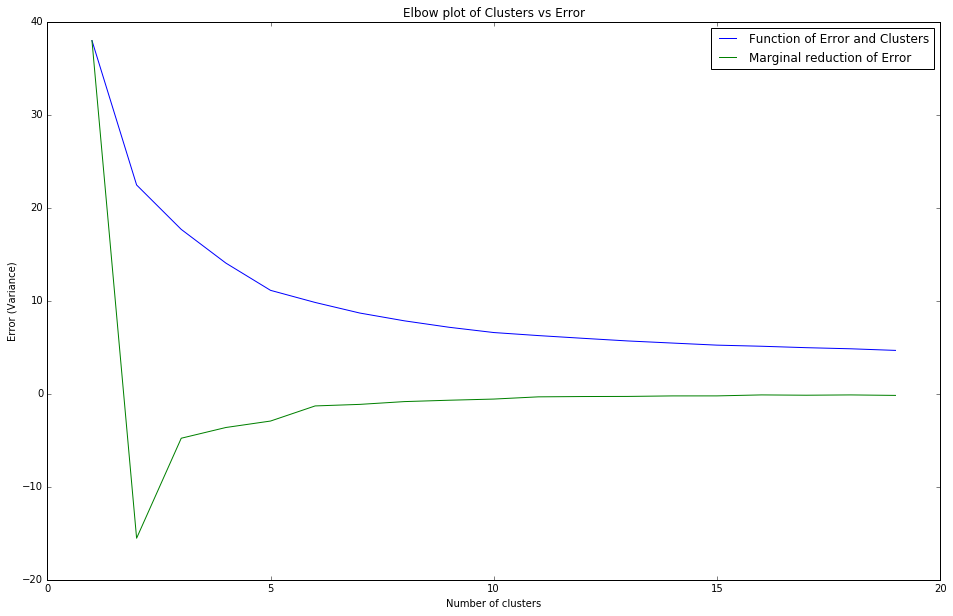

Best number of Clusters (at the elbow)= 7   Error = 8.6836   Marginal Reduction of Error = 67.2818


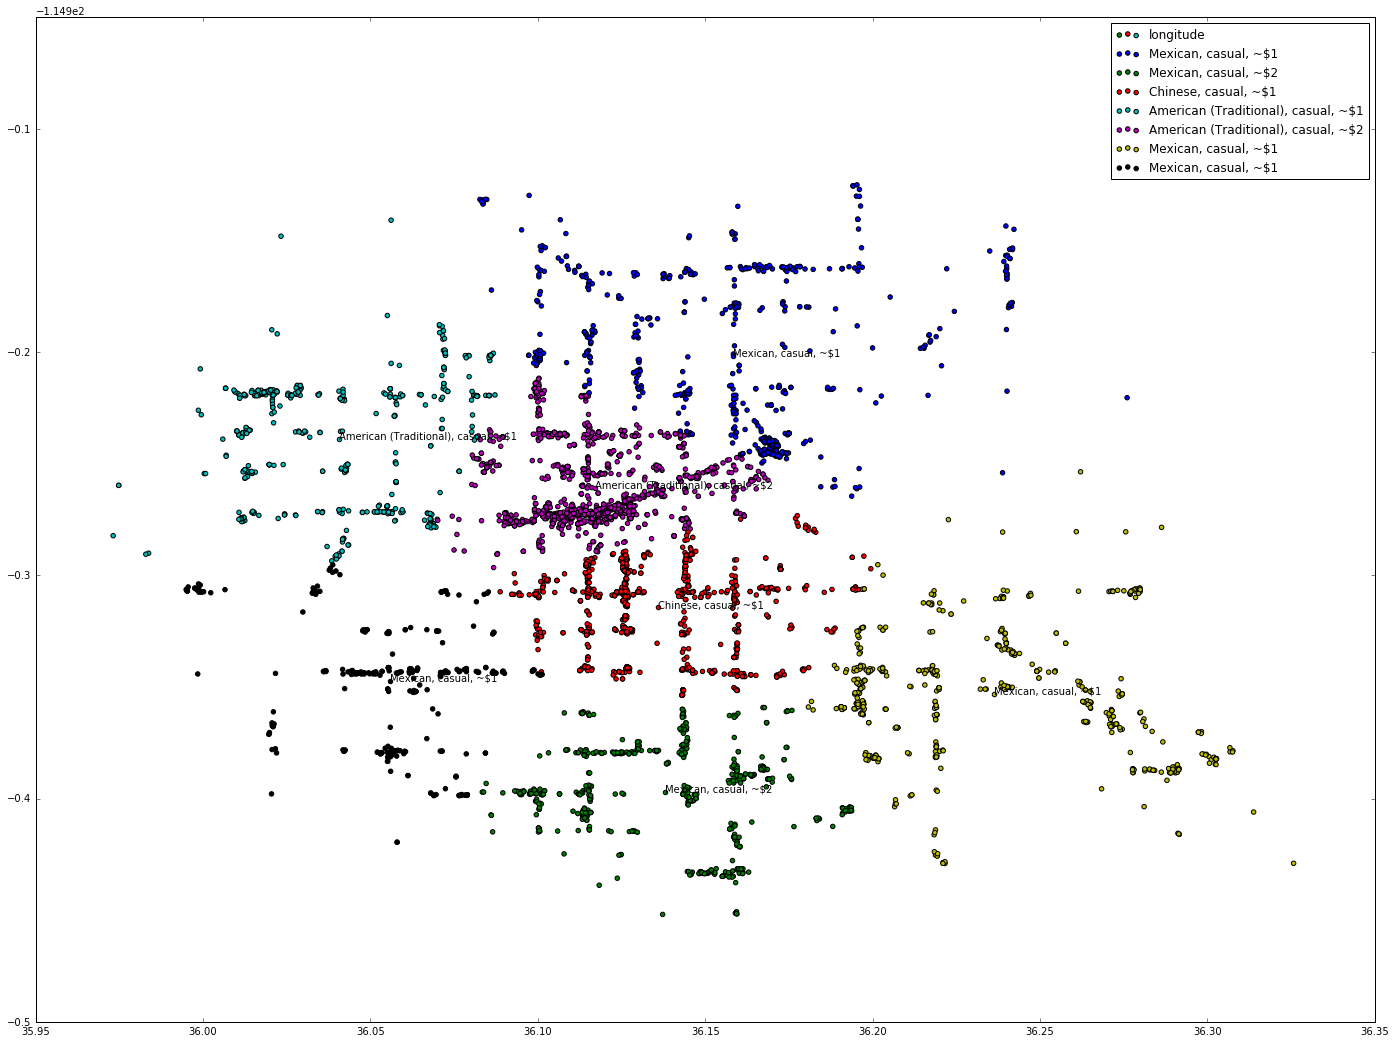

Number of Clusters: 7

	Cluster #: 0
	Color of cluster: b
	Name of cluster (based on common elements in cluster): Mexican, casual, ~$1
	Number of restaurants: 654
	Top 5 categories of restaurants (name,#):
	[('Mexican', 134), ('American (Traditional)', 67), ('Burgers', 53), ('American (New)', 45), ('Bars', 45)]
	Top 5 attributes of restaurants (name,#):
	 [('casual', 203), ('lunch', 165), ('dinner', 96), ('brunch', 69), ('breakfast', 51)]
	Average price range of restaurants: 1.43137254902
	Minimum euclidean similarity value: 0.999211202999
	Average euclidean similarity value: 0.999829713055

	Cluster #: 1
	Color of cluster: g
	Name of cluster (based on common elements in cluster): Mexican, casual, ~$2
	Number of restaurants: 553
	Top 5 categories of restaurants (name,#):
	[('Mexican', 64), ('Bars', 55), ('Italian', 53), ('American (Traditional)', 53), ('American (New)', 52)]
	Top 5 attributes of restaurants (name,#):
	 [('casual', 310), ('lunch', 196), ('dinner', 157), ('brunch', 74), 

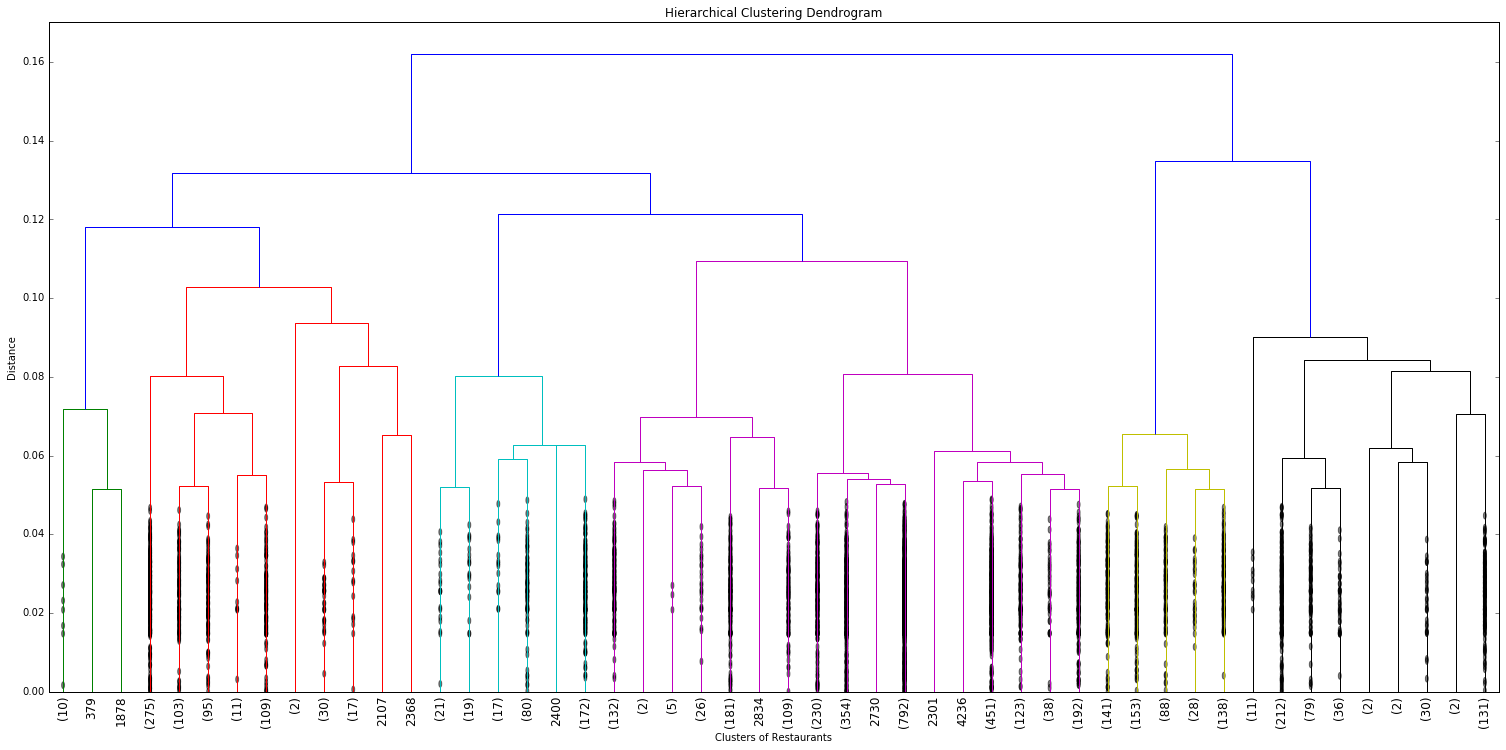

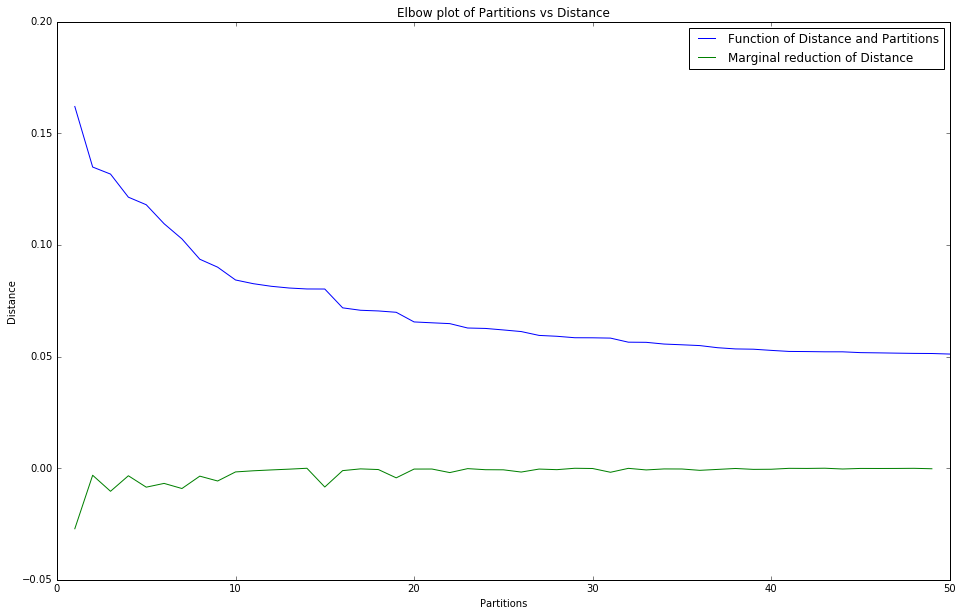

Best number of Partitions (at the elbow)= 10   Distance = 0.0827


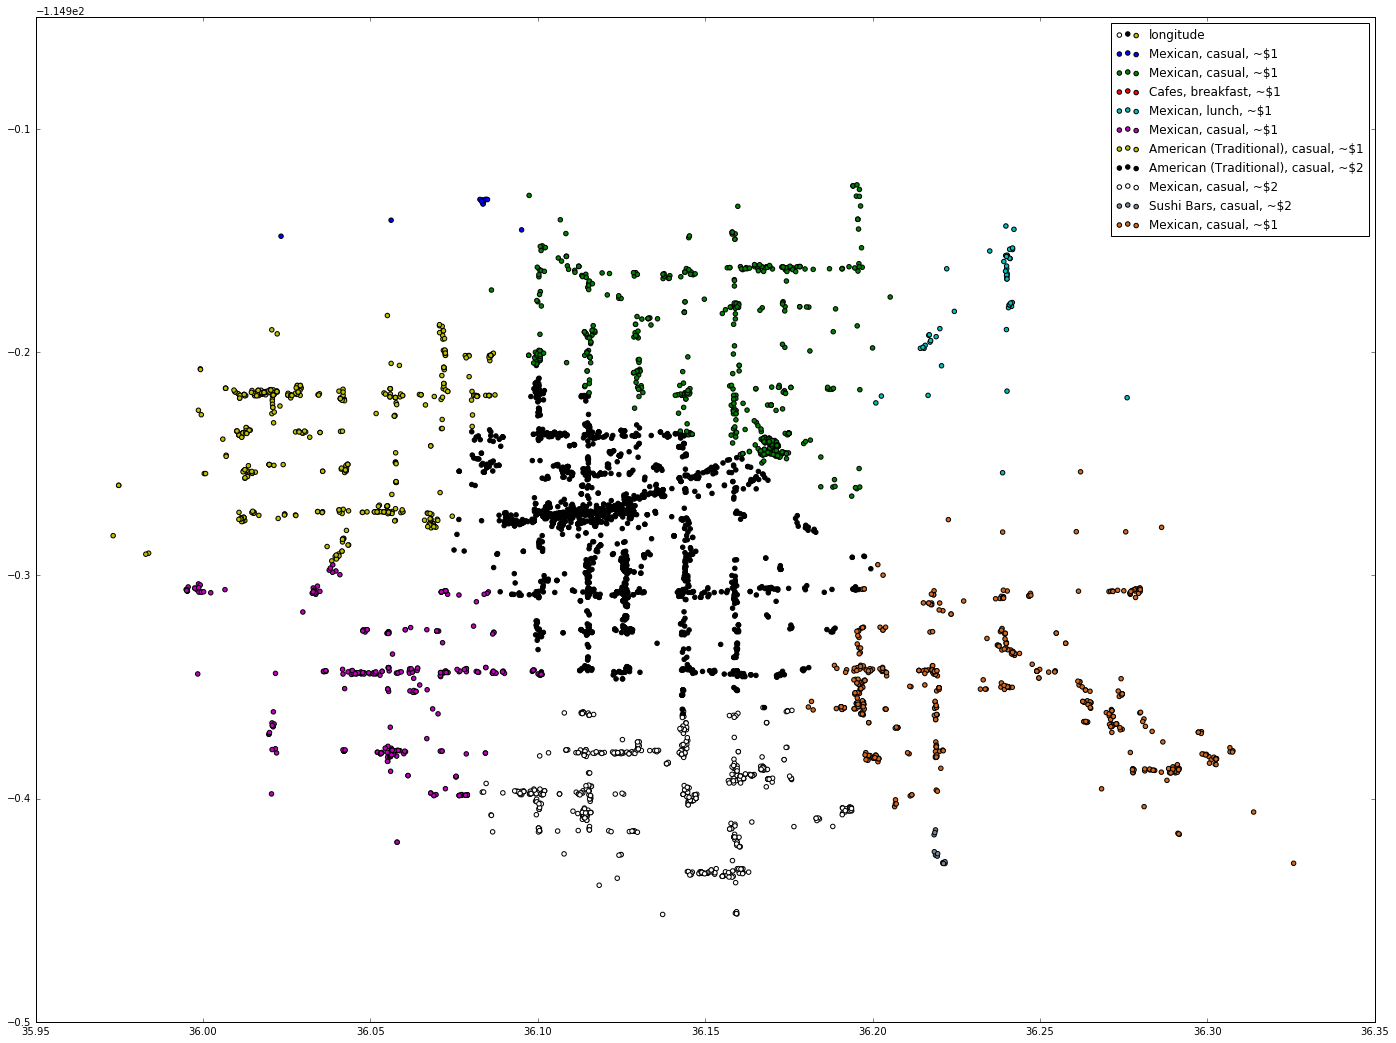

Number of Clusters: 10
Cophenetic Correlation Coefficient: 0.7205

	Cluster #: 0
	Color of cluster: b
	Name of cluster (based on common elements in cluster): Mexican, casual, ~$1
	Number of restaurants: 12
	Top 5 categories of restaurants (name,#):
	[('Mexican', 4), ('American (Traditional)', 3), ('Bars', 2), ('Breakfast & Brunch', 1), ('Chicken Wings', 1)]
	Top 5 attributes of restaurants (name,#):
	 [('casual', 5), ('breakfast', 2), ('latenight', 2), ('brunch', 1), ('lunch', 1)]
	Average price range of restaurants: 1.25
	Minimum euclidean similarity value: 0.999415572603
	Average euclidean similarity value: 0.999785581445

	Cluster #: 1
	Color of cluster: g
	Name of cluster (based on common elements in cluster): Mexican, casual, ~$1
	Number of restaurants: 593
	Top 5 categories of restaurants (name,#):
	[('Mexican', 123), ('American (Traditional)', 57), ('Burgers', 47), ('Bars', 41), ('American (New)', 39)]
	Top 5 attributes of restaurants (name,#):
	 [('casual', 190), ('lunch', 153)

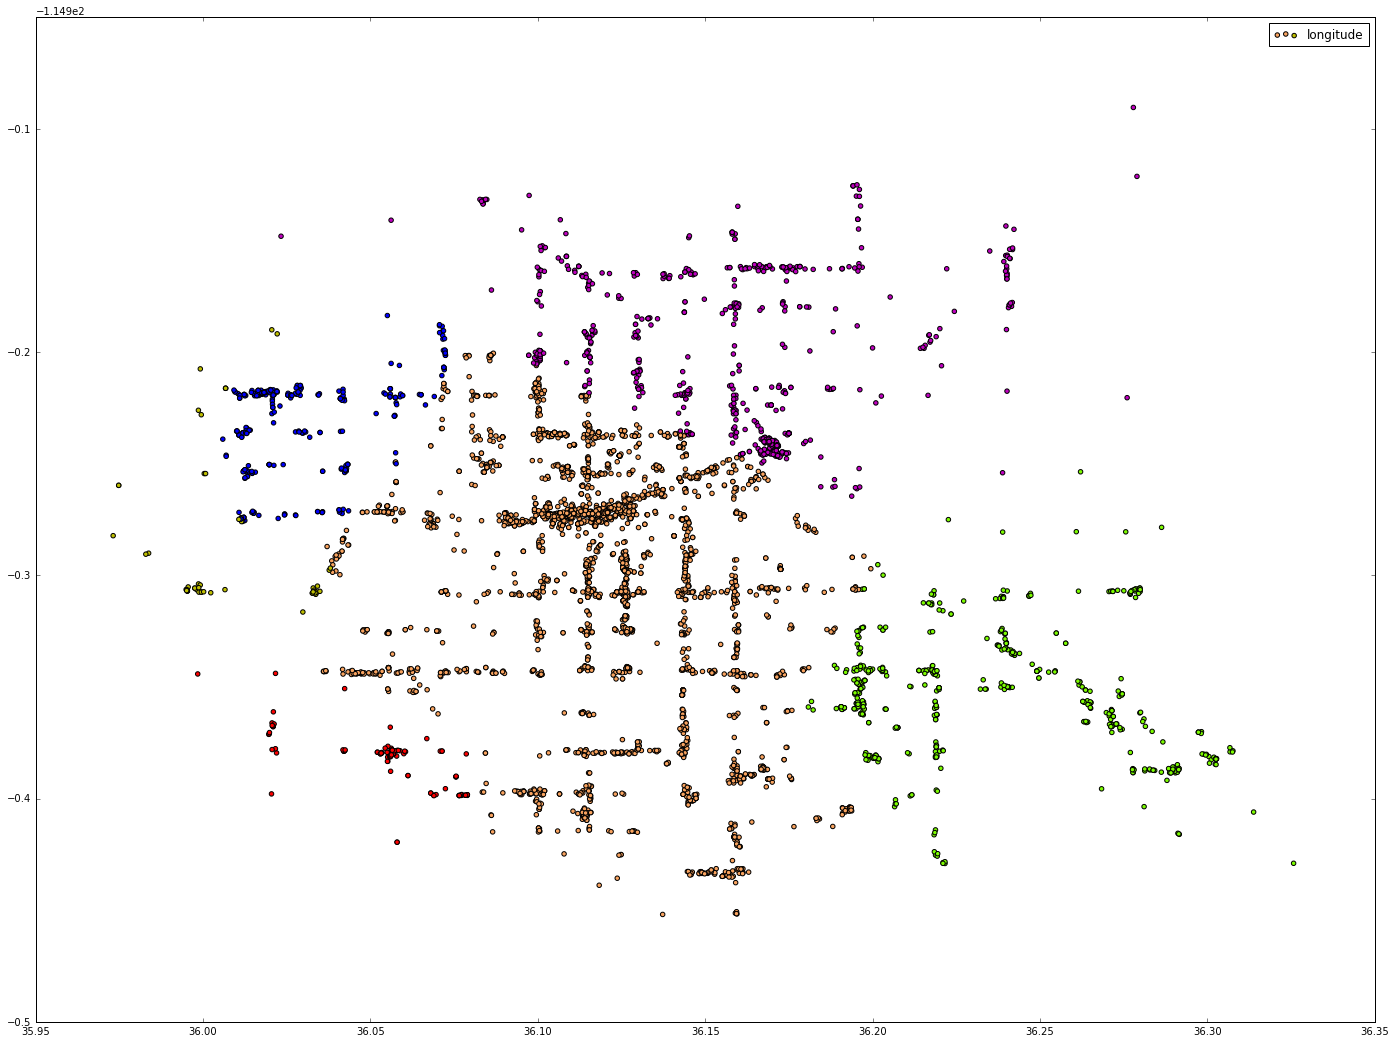

Number of Clusters: 7

	Cluster #: 0
	Color of cluster: b
	Name of cluster (based on common elements in cluster): Mexican, casual, ~$1
	Number of restaurants: 291
	Top 5 categories of restaurants (name,#):
	[('Mexican', 38), ('American (Traditional)', 30), ('Bars', 19), ('Burgers', 19), ('Japanese', 18)]
	Top 5 attributes of restaurants (name,#):
	 [('casual', 143), ('lunch', 116), ('dinner', 70), ('brunch', 31), ('breakfast', 20)]
	Average price range of restaurants: 1.48028673835
	Minimum euclidean similarity value: 0.999247011462
	Average euclidean similarity value: 0.999821154335

	Cluster #: 18
	Color of cluster: g
	Name of cluster (based on common elements in cluster): Mexican, casual, ~$2
	Number of restaurants: 824
	Top 5 categories of restaurants (name,#):
	[('Mexican', 97), ('Bars', 73), ('American (Traditional)', 67), ('American (New)', 60), ('Italian', 60)]
	Top 5 attributes of restaurants (name,#):
	 [('casual', 415), ('lunch', 290), ('dinner', 206), ('brunch', 96), ('brea

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from matplotlib.colors import LogNorm
from sklearn import mixture
import gmplot

from sklearn.metrics.pairwise import pairwise_distances_argmin

%matplotlib inline


path = "/Users/ALaw/Desktop/Stuff/2016 Spring/591/submissions/591-hw/hw2-submission/"
dataname = path + "business_data.csv"

try:
    data = pd.DataFrame.from_csv(dataname)
except IOError:
    data = extract()

def kmeans_clustering(n_iterations=20):
    
    print "\nK-means++ Clustering\n"
    """
    Using the elbow method, first plot out the error function vs number of clusters to determine optimum
    After determination:
        - Use k-means++ to cluster vectors together, labeling each restaurant to a cluster
        - inside each cluster, measure euclidean similarity of clusters and output results and label each culinary district
        - plot each cluster with appropiate labels, show results of similarity"""
    
    #Get coordinates in order
    x = data['latitude']
    y = data['longitude']
    
    vectors = data.as_matrix()
    for p in range(2,len(vectors[0])):
        vectors[:,p] *= 2.0/len(vectors[0])

    #Elbow method and plotting
    error = np.zeros(n_iterations)
    error[0] = 0;
    for k in range(1,n_iterations):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(vectors)
        error[k] = kmeans.inertia_
    plt.figure(figsize=(16,10))
    plt.plot(range(1,len(error)),error[1:], label = 'Function of Error and Clusters')
    plt.plot(range(1,len(error)),np.diff(error), label = 'Marginal reduction of Error')
    plt.title('Elbow plot of Clusters vs Error')
    plt.xlabel('Number of clusters')
    plt.ylabel('Error (Variance)')
    plt.legend()
    plt.show()
    
    #Use first order of discrete difference to find point where marginal reduction of error < 1
    i = 0
    error_diff = np.diff(error)
    while(abs(error_diff[i]) > 1):
        i+= 1
    print "Best number of Clusters (at the elbow)= %i   Error = %.4f   Marginal Reduction of Error = %.4f"%(i,error[i],sum(abs(np.diff(error)[:i]))) 
    
    #i = ideal # of clusters, rerun clustering using n_clusters = i
    num_clusters = i
    k_means = KMeans(init='k-means++', n_clusters=i, n_init=10)
    k_means.fit_predict(vectors)
    coordinates_labels = k_means.labels_
    coordinates_cluster_centers = k_means.cluster_centers_
    coordinates_unique_labels = np.unique(coordinates_labels)
    
    colors = ['b','g','r','c','m','y','k','w','LightSlateGray','Chocolate','SeaGreen','LightBlue','PaleVioletRed','DarkSlateGray','Purple','Khaki','LawnGreen','SteelBlue','SandyBrown']
    
    plt.figure(figsize=(24,18))
    plt.scatter(x, y,c = [colors[i] for i in coordinates_labels])
    
    #store cluster assignment into dataframe
    data['K-means++ label'] = coordinates_labels
    data.to_csv('business_data_kmeans.csv')
    
    #Find the most common restaurant category type,attribute type & price range in each cluster
    label_data = find_common_types(data,coordinates_unique_labels,'K-means++ label')
    
    #Use top category + attribute to label cluster centers
    for j in range(len(coordinates_cluster_centers)):
        plt.scatter(coordinates_cluster_centers[j][0],coordinates_cluster_centers[j][1], c = colors[j], label = label_data[j])
        plt.annotate(label_data[j],xy=coordinates_cluster_centers[j][0:2])
    
    plt.legend()
    plt.show()
    
    #In each cluster, calculate a euclidean similarity matrix using categories and attributes
    sim_matrices = []
    for l in coordinates_unique_labels:
        sim_matrices.append(calc_sim_matrix(data.loc[data['K-means++ label'] == l],'cosine'))
    
    #Return the average similarity of all items inside the cluster
    sim_list = []
    for l in coordinates_unique_labels:
        minimum = sim_matrices[l].flatten().min()
        average = np.average(sim_matrices[l].flatten())
        sim_list.append([minimum,average])
    
    #Print statstics, cluster details, similarity minimums and averages
    print("Number of Clusters: %i"%num_clusters)
    print("")
    categories = list(data.columns.values)[2:119]
    attributes = list(data.columns.values)[119:134]
    
    for l in coordinates_unique_labels:
        print("\tCluster #: %i"%l)
        print("\tColor of cluster: " + colors[l])
        print("\tName of cluster (based on common elements in cluster): " + label_data[l])
        data_range = data.loc[data['K-means++ label'] == l]
        print("\tNumber of restaurants: " + str(len(data_range)))
        
        cat_count = []
        for cat in categories:
            cat_count.append(data_range[cat].sum(axis=0))
        cat_count = np.array(cat_count)
        cat_index = []
        for i in cat_count.argsort()[(-1*5):][::-1]:
            cat_index.append((categories[i],cat_count[i]))
            
        attrib_count = []
        for atr in attributes:
            attrib_count.append(data_range[atr].sum(axis=0))
        attrib_count = np.array(attrib_count)
        attrib_index = []
        for i in attrib_count.argsort()[(-1*5):][::-1]:
            attrib_index.append((attributes[i],attrib_count[i]))
            
        print("\tTop " + str(5) + " categories of restaurants (name,#):\n\t" + str(cat_index))
        print("\tTop " + str(5) + " attributes of restaurants (name,#):\n\t " + str(attrib_index))
        
        prices = np.array([p for p in list(data_range['Price Range']) if p != 0])
        print("\tAverage price range of restaurants: " + str(np.average(prices)))
        print("\tMinimum euclidean similarity value: " + str(sim_list[l][0]))
        print("\tAverage euclidean similarity value: " + str(sim_list[l][1]))
        print("")

def hierarchical_clustering(n_clusters = 50):
    
    print "\nHierarchical Clustering\n"
    
    """
    First create dendogram plot to visualize clustering steps based on average distances. 
    Then, using the elbow method, plot out the distance growth vs number of partitions to determine optimum.
    Using n = optimum:
        Define labels by color
        Calculate similarity indexs
        Plot each cluster with appropiate labels, show results of similarity
    """
    
    #Get coordinates in order
    x = data['latitude']
    y = data['longitude']
    
    vectors = data.as_matrix()
    for p in range(2,len(vectors[0])):
        vectors[:,p] *= 2.0/len(vectors[0])
        
    #Generate the linkage matrix
    link_matrix = linkage(vectors, 'average', metric='euclidean')
    
    #Calculate cophenetic correlation coefficient 
    c, coph_dists = cophenet(link_matrix, pdist(vectors))

    #Plotting dendogram 
    plt.figure(figsize=(26, 12))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Clusters of Restaurants')
    plt.ylabel('Distance')
    dendrogram(link_matrix,truncate_mode='lastp',  p=n_clusters, leaf_rotation=90.,leaf_font_size=12.,show_contracted=True)
    plt.show()
    
    #Elbow method and plotting
    dist = link_matrix[-n_clusters:, 2]
    dist_rev = dist[::-1]
    dist_diff = np.diff(dist_rev)
    
    plt.figure(figsize=(16,10))
    plt.plot(range(1,len(dist_rev)+1), dist_rev, label = 'Function of Distance and Partitions')
    plt.plot(range(1,len(dist_diff)+1), dist_diff, label = 'Marginal reduction of Distance')
    plt.title('Elbow plot of Partitions vs Distance')
    plt.xlabel('Partitions')
    plt.ylabel('Distance')
    plt.legend()
    plt.show()
    
    #Use distance find point where partitions of distance growth < 0.08
    i = 0
    while(abs(dist_diff[i]) > 0.00125):
        i+= 1
    print "Best number of Partitions (at the elbow)= %i   Distance = %.4f"%(i,dist_rev[i]) 
    
    #i = ideal number of partitions
    n_clusters = i
    clusters_labels = fcluster(link_matrix, n_clusters, criterion='maxclust')
    clusters_labels = [i-1 for i in clusters_labels]
    clusters_unique = np.unique(clusters_labels)
    
    #store cluster assignment into dataframe
    data['hierarchical label'] = clusters_labels
    data.to_csv('business_data_hierarchical.csv')
    
    colors = ['b','g','r','c','m','y','k','w','LightSlateGray','Chocolate','SeaGreen','LightBlue','PaleVioletRed','DarkSlateGray','Purple','Khaki','LawnGreen','SteelBlue','SandyBrown']
    
    plt.figure(figsize=(24,18))
    plt.scatter(x, y,c = [colors[i] for i in clusters_labels])
    
    #Find the most common restaurant category type,attribute type & price range in each cluster
    label_data = find_common_types(data,clusters_unique,'hierarchical label')
    
    #Use top category + attribute to label cluster centers
    for j in clusters_unique:
        x = data.loc[data['hierarchical label'] == j]['latitude'].iloc[0]
        y = data.loc[data['hierarchical label'] == j]['longitude'].iloc[0]
        plt.scatter(x,y, c = colors[j], label = label_data[j])
    
    plt.legend()
    plt.show()
    
    #In each cluster, calculate a euclidean similarity matrix using categories and attributes
    sim_matrices = []
    for l in clusters_unique:
        sim_matrices.append(calc_sim_matrix(data.loc[data['hierarchical label'] == l],'cosine'))
    
    #Return the average similarity of all items inside the cluster
    sim_list = []
    for l in clusters_unique:
        minimum = sim_matrices[l].flatten().min()
        average = np.average(sim_matrices[l].flatten())
        sim_list.append([minimum,average])
    
    #Print statstics, cluster details, similarity minimums and averages
    print("Number of Clusters: %i"%n_clusters)
    print("Cophenetic Correlation Coefficient: %.4f"%c)
    print("")
    categories = list(data.columns.values)[2:119]
    attributes = list(data.columns.values)[119:134]
    for l in clusters_unique:
        print("\tCluster #: %i"%l)
        print("\tColor of cluster: " + colors[l])
        print("\tName of cluster (based on common elements in cluster): " + label_data[l])
        data_range = data.loc[data['hierarchical label'] == l]
        print("\tNumber of restaurants: " + str(len(data_range)))
        
        cat_count = []
        for cat in categories:
            cat_count.append(data_range[cat].sum(axis=0))
        cat_count = np.array(cat_count)
        cat_index = []
        for i in cat_count.argsort()[(-1*5):][::-1]:
            cat_index.append((categories[i],cat_count[i]))
            
        attrib_count = []
        for atr in attributes:
            attrib_count.append(data_range[atr].sum(axis=0))
        attrib_count = np.array(attrib_count)
        attrib_index = []
        for i in attrib_count.argsort()[(-1*5):][::-1]:
            attrib_index.append((attributes[i],attrib_count[i]))
            
        print("\tTop " + str(5) + " categories of restaurants (name,#):\n\t" + str(cat_index))
        print("\tTop " + str(5) + " attributes of restaurants (name,#):\n\t " + str(attrib_index))
        
        prices = np.array([p for p in list(data_range['Price Range']) if p != 0])
        print("\tAverage price range of restaurants: " + str(np.average(prices)))
        print("\tMinimum euclidean similarity value: " + str(sim_list[l][0]))
        print("\tAverage euclidean similarity value: " + str(sim_list[l][1]))
        print("")

def gmm_clustering():
    
    print "\nGaussian Mixture Model Clustering\n"
    
    #Get coordinates in order
    x = data['latitude']
    y = data['longitude']
    
    vectors = data.as_matrix()
    for p in range(2,len(vectors[0])):
        vectors[:,p] *= 2.0/len(vectors[0])
    
    #num_clusters = ideal # of clusters
    num_clusters = len(vectors[0])
    
    gmm = mixture.GMM(n_components=num_clusters, covariance_type='diag')
    gmm.fit(vectors)
    coordinates_labels = gmm.predict(vectors)
    coordinates_unique_labels = np.unique(coordinates_labels)
    
    colors = ['b','g','r','c','m','y','k','w','LightSlateGray','Chocolate','SeaGreen','LightBlue','PaleVioletRed','DarkSlateGray','Purple','Khaki','LawnGreen','SteelBlue','SandyBrown','Plum','Fuchsia']
    
    plt.figure(figsize=(24,18))
    plt.scatter(x, y, c=[colors[i%len(colors)] for i in coordinates_labels])
    
    #store cluster assignment into dataframe
    data['GMM label'] = coordinates_labels
    data.to_csv('business_data_gmm.csv')
    
    #Find the most common restaurant category type,attribute type & price range in each cluster
    label_data = find_common_types(data,coordinates_unique_labels,'GMM label')
    
    #Use top category + attribute to label cluster centers
    '''
    for j in range(len(coordinates_cluster_centers)):
        plt.scatter(coordinates_cluster_centers[j][0],coordinates_cluster_centers[j][1], c = colors[j], label = label_data[j])
        plt.annotate(label_data[j],xy=coordinates_cluster_centers[j][0:2])
    '''
    plt.legend()
    plt.show()
    
    #In each cluster, calculate a euclidean similarity matrix using categories and attributes
    sim_matrices = []
    for l in coordinates_unique_labels:
        sim_matrices.append(calc_sim_matrix(data.loc[data['GMM label'] == l],'cosine'))
    
    #Return the average similarity of all items inside the cluster
    sim_list = []
    for l in range(len(coordinates_unique_labels)):
        minimum = sim_matrices[l].flatten().min()
        average = np.average(sim_matrices[l].flatten())
        sim_list.append([minimum,average])
    
    #Print statstics, cluster details, similarity minimums and averages
    print("Number of Clusters: %i"%len(coordinates_unique_labels))
    print("")
    categories = list(data.columns.values)[2:119]
    attributes = list(data.columns.values)[119:134]
    
    for l in range(len(coordinates_unique_labels)):
        print("\tCluster #: %i"%coordinates_unique_labels[l])
        print("\tColor of cluster: " + colors[l%len(colors)])
        print("\tName of cluster (based on common elements in cluster): " + label_data[l])
        data_range = data.loc[data['GMM label'] == coordinates_unique_labels[l]]
        print("\tNumber of restaurants: " + str(len(data_range)))
        
        cat_count = []
        for cat in categories:
            cat_count.append(data_range[cat].sum(axis=0))
        cat_count = np.array(cat_count)
        cat_index = []
        for i in cat_count.argsort()[(-1*5):][::-1]:
            cat_index.append((categories[i],cat_count[i]))
            
        attrib_count = []
        for atr in attributes:
            attrib_count.append(data_range[atr].sum(axis=0))
        attrib_count = np.array(attrib_count)
        attrib_index = []
        for i in attrib_count.argsort()[(-1*5):][::-1]:
            attrib_index.append((attributes[i],attrib_count[i]))
            
        print("\tTop " + str(5) + " categories of restaurants (name,#):\n\t" + str(cat_index))
        print("\tTop " + str(5) + " attributes of restaurants (name,#):\n\t " + str(attrib_index))
        
        prices = np.array([p for p in list(data_range['Price Range']) if p != 0])
        print("\tAverage price range of restaurants: " + str(np.average(prices)))
        print("\tMinimum euclidean similarity value: " + str(sim_list[l][0]))
        print("\tAverage euclidean similarity value: " + str(sim_list[l][1]))
        print("")
    
def find_common_types(data,labels,name):
    '''For each cluster, sum up columns and return the most common category, attribute and price range'''
    categories = list(data.columns.values)[2:119]
    attributes = list(data.columns.values)[119:134]
    n = len(labels)
    
    label_data = []
    for label in labels:
        data_range = data.loc[data[name] == label]
        cat_count = []
        for cat in categories:
            cat_count.append(data_range[cat].sum(axis=0))
        cat_count = np.array(cat_count)
        
        attrib_count = []
        for atr in attributes:
            attrib_count.append(data_range[atr].sum(axis=0))
        attrib_count = np.array(attrib_count)
    
        price_range = list(data_range['Price Range'])
        price_range = max(set(price_range), key=price_range.count)
        if price_range != 0:
            label_data.append(str(categories[cat_count.argmax()]) + ', ' + str(attributes[attrib_count.argmax()]) + ', ~$' + str(price_range))
        else:
            label_data.append(str(categories[cat_count.argmax()]) + ', ' + str(attributes[attrib_count.argmax()]))
    return label_data

def calc_sim_matrix(data,met):
    return 1-metrics.pairwise_distances(data, metric=met)


kmeans_clustering()    
hierarchical_clustering()
gmm_clustering()

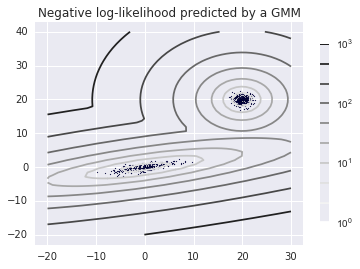

In [274]:

    colors = ['b','g','r','c','m','y','k','w','LightSlateGray','Chocolate','SeaGreen','LightBlue','PaleVioletRed','DarkSlateGray','Purple','Khaki','LawnGreen','SteelBlue','SandyBrown']
    
    c
    print y_pred
    plt.figure(figsize=(24,18))
    plt.scatter(x, y, c=[colors[i%len(colors)] for i in y_pred])
    plt.show()

Visualize your clusters using each technique. Label your clusters. **(10 pts)**

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

Give a short (detailed) analysis comparing the 3 techniques. **(10 pts)**

-----------------

In [ ]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()